In [341]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


#Hyperparameter Tuning
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

# Package to visualize Decision Tree
from sklearn import tree

from IPython.display import Markdown, display
import pickle
import time

# Reading In Data

In [234]:
data = pd.read_csv("Data Files/Cleaned_Data_for_ML.csv")
data.head()

,Tm,Capacity,Week,Attendance,Year,Away Team Wins,Home Team Wins,Time,International
0,BUF,71608,1,69519,2013,0,0,0,0
1,CAR,74867,1,73294,2013,0,0,0,0
2,CHI,61500,1,62213,2013,0,0,0,0
3,CLE,67431,1,71513,2013,0,0,0,0
4,DAL,80000,1,85348,2013,0,0,0,0


In [271]:
data.groupby("Time").size()

Time
0    2334
1      90
2      87
3      79
4      15
dtype: int64

# Exploratory Data Analysis

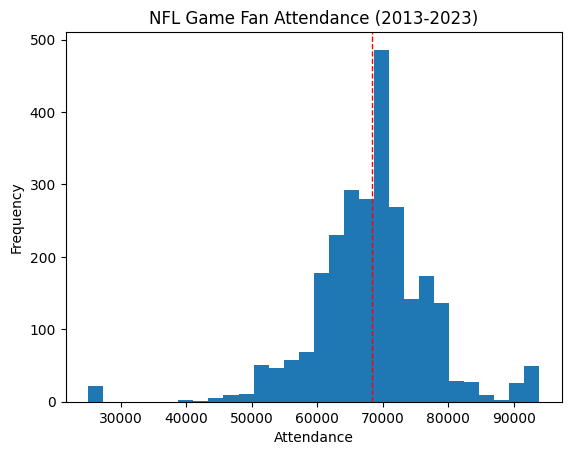

In [178]:
#Histogram

plt.hist(data["Attendance"], bins = 30)
plt.axvline(data["Attendance"].mean(), color='red', linestyle='dashed', linewidth=1)


plt.title("NFL Game Fan Attendance (2013-2023)")
plt.xlabel("Attendance")
plt.ylabel("Frequency")
plt.show()

In [179]:
data["Attendance"].std()
data["Attendance"].mean()
print(f"Mean Attendance: {int(data["Attendance"].mean())}\n"
      f"Std Dev Attendance: {int(data["Attendance"].std())}\n"
      f"Three Std Dev Below Mean: {int(data["Attendance"].mean() - 3*data["Attendance"].std())}\n"
      f"Three Std Dev Above Mean: {int(data["Attendance"].mean() + 3*data["Attendance"].std())}")

Mean Attendance: 68260
Std Dev Attendance: 8943
Three Std Dev Below Mean: 41430
Three Std Dev Above Mean: 95090


## Finding and Removing Outliers

In [180]:
data[data["Attendance"] < 40000].groupby("Tm").size()

Tm
BUF     1
CIN     1
LAC    22
dtype: int64

A large majority of low Attendance outliers came from the Los Angeles Chargers, who temporarily played at College Soccer stadium with a Capacity of 27,500, during the construction of SoFi Stadium. 

In [205]:
# Removing Chargers Data (2017-2020)
data = data[~((data["Tm"] == "LAC") & (data["Year"].isin([2017,2018,2019])))]

In [182]:
data[data["Attendance"] > 90000].groupby("Tm").size()

Tm
DAL    75
LAR     1
dtype: int64

An overwhelming majority of high attendance outliers came from the Dallas Cowboys, AKA: America's Team. This comes to no surprise because not only do the Dallas Cowboys have the largest stadium capacity in the NFL, they also have the largest fanbase.

In [206]:
# Removing Cowboys Data
data = data[~(data["Tm"] == "DAL")]

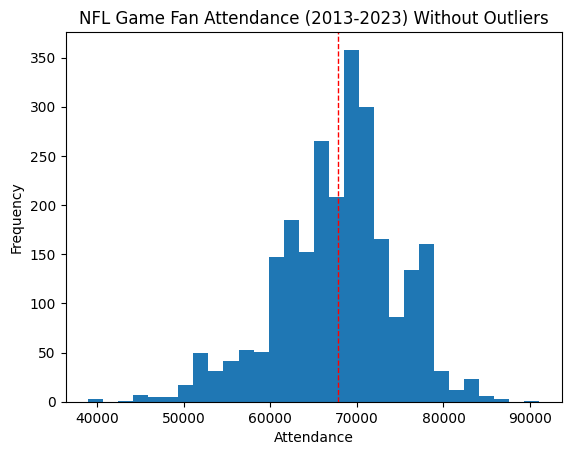

In [184]:
#Histogram Without Outliers

plt.hist(data["Attendance"], bins = 30)
plt.axvline(data["Attendance"].mean(), color='red', linestyle='dashed', linewidth=1)


plt.title("NFL Game Fan Attendance (2013-2023) Without Outliers")
plt.xlabel("Attendance")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'Attendance')

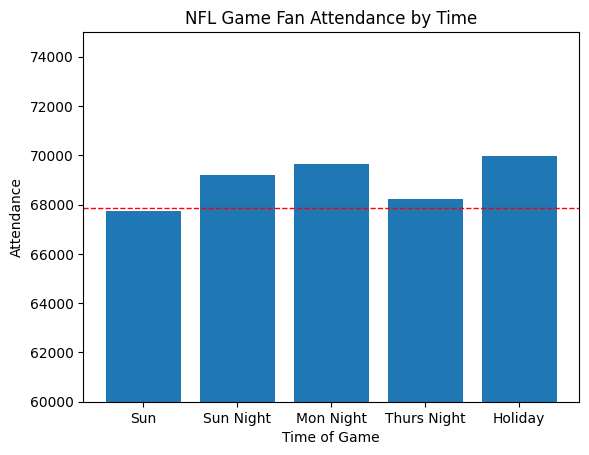

In [185]:
#Group By Time

gb_time = data.groupby("Time").agg(mean = ("Attendance", "mean"))
times = ["Sun", "Sun Night", "Mon Night", "Thurs Night", "Holiday"]

plt.bar(times, gb_time["mean"])
plt.ylim(60000, 75000)
plt.axhline(data["Attendance"].mean(), color='red', linestyle='dashed', linewidth=1)
plt.title("NFL Game Fan Attendance by Time")
plt.xlabel("Time of Game")
plt.ylabel("Attendance")

Holiday Games appear to have the largest turnouts, which is to be expected, because not only are people off from work, but these games typically involve highly ranked teams that are playoff contenders. Monday night is surprisingly the most attended "Primetime" game. Conversely, Thursday Night is the least attended "Primetime" game because these spots feature bottom-half teams more so than Sunday or Monday Night. Lastly, Sunday during the day is the lease attended overall. This makes sense because of all the teams that are poor performers during the season. These teams typically see a less filled stadium as fans give up hope.

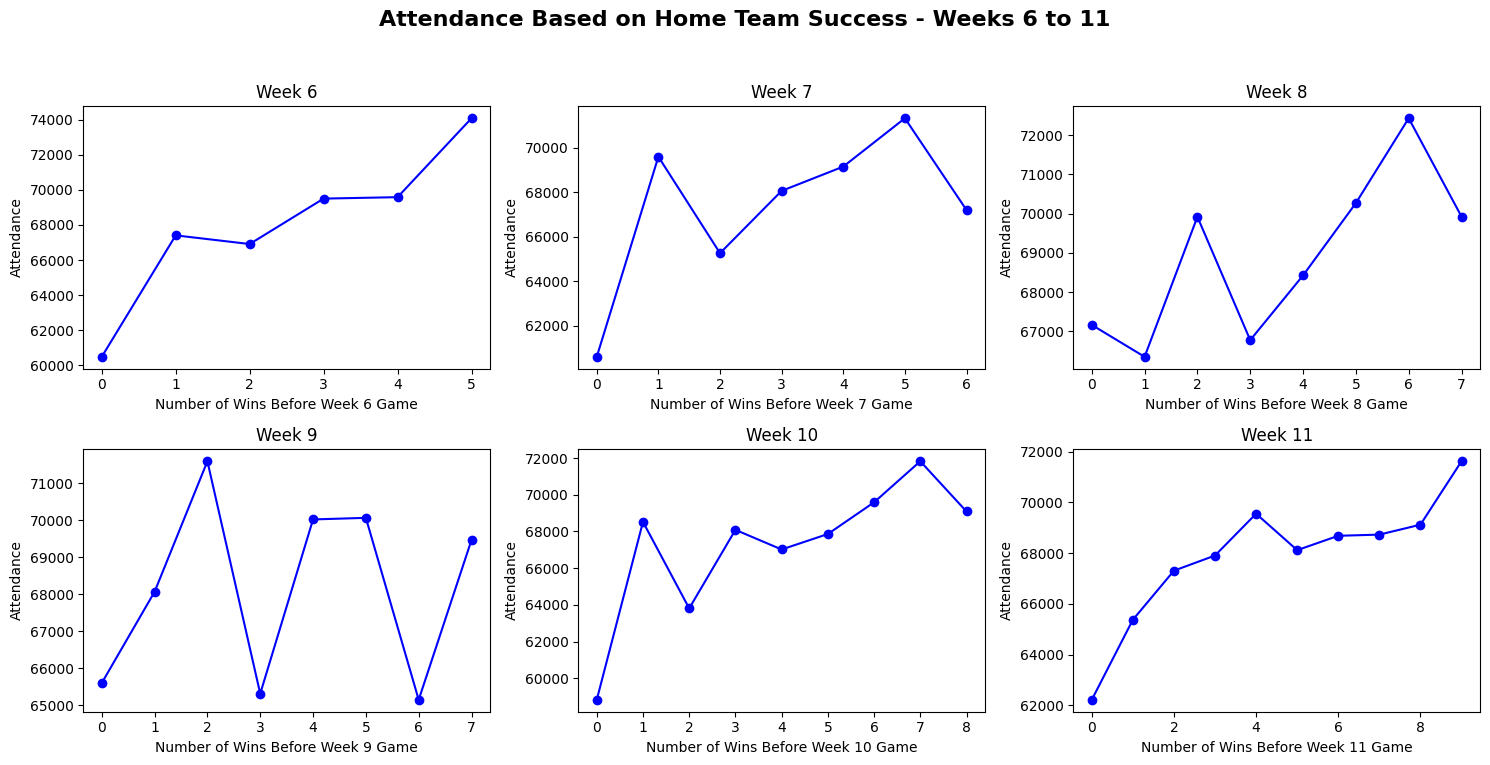

In [186]:
weeks = [6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

for i, week in enumerate(weeks):
    # Select the current subplot
    ax = axs[i // 3, i % 3]  # Determine subplot position

    # Filter data for the current week
    wins_df = data[(data["Week"] == week) & (data["Home Team Wins"] != -1)].groupby("Home Team Wins").agg(mean_attendance=("Attendance", "mean"))

    # Plot the data
    ax.plot(wins_df.index, wins_df["mean_attendance"], marker='o', linestyle='-', color='b')

    # Set title and labels
    ax.set_title(f"Week {week}")
    ax.set_xlabel(f"Number of Wins Before Week {week} Game")
    ax.set_ylabel("Attendance")

plt.suptitle("Attendance Based on Home Team Success - Weeks 6 to 11", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Despite the sporadic line graphs in week 8 and 9, there is a general upward correlation between number of games won and Attendance. This makes sense, as teams with good on field performance attract more of their fans to attend a game.

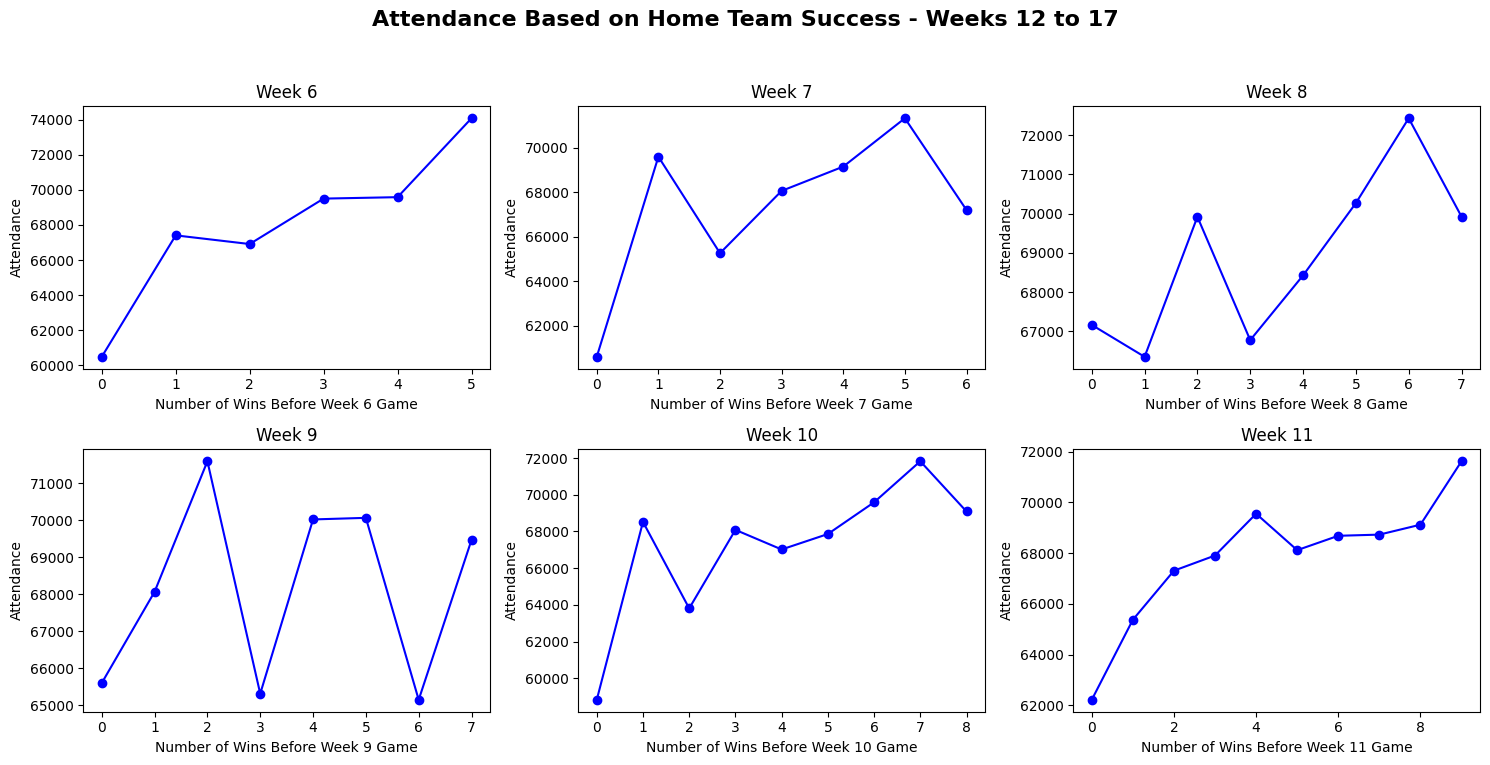

In [187]:
weeks2 = [12, 13, 14, 15, 16, 17]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

for i, week in enumerate(weeks):
    # Select the current subplot
    ax = axs[i // 3, i % 3]  # Determine subplot position

    # Filter data for the current week
    wins_df = data[(data["Week"] == week) & (data["Home Team Wins"] != -1)].groupby("Home Team Wins").agg(mean_attendance=("Attendance", "mean"))

    # Plot the data
    ax.plot(wins_df.index, wins_df["mean_attendance"], marker='o', linestyle='-', color='b')

    # Set title and labels
    ax.set_title(f"Week {week}")
    ax.set_xlabel(f"Number of Wins Before Week {week} Game")
    ax.set_ylabel("Attendance")

plt.suptitle("Attendance Based on Home Team Success - Weeks 12 to 17", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Later in the season, this correlation is more prominent. Additionally, the wider range in number of wins displays this relationship well.

## Correlation Matrix

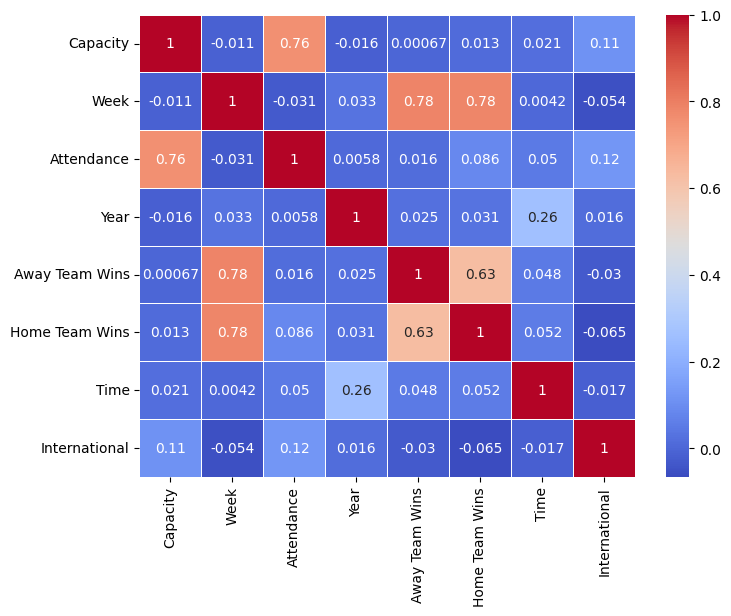

In [189]:
correlation_matrix = data.drop(columns = ["Tm"]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.show()

From all of the correlations with "Attendance", Capacity obviously has the largest correlation coefficient (0.78). 

# Machine Learning

In [207]:
# Setting up Independent and Dependent Variables
predictors = ["Capacity", "Week", "Away Team Wins", "Home Team Wins", "Time", "International"]
outcome = "Attendance"

data["Time"] = data["Time"].astype(str)

x = pd.get_dummies(data[predictors], drop_first = True)
y = data[outcome]

for i in range(1,5):
    x[f"Time_{i}"] = x[f"Time_{i}"].astype(int)


x.head()

,Capacity,Week,Away Team Wins,Home Team Wins,International,Time_1,Time_2,Time_3,Time_4
0,71608,1,0,0,0,0,0,0,0
1,74867,1,0,0,0,0,0,0,0
2,61500,1,0,0,0,0,0,0,0
3,67431,1,0,0,0,0,0,0,0
5,76125,1,0,0,0,0,0,0,0


In [208]:
y.head()

0    69519
1    73294
2    62213
3    71513
5    76977
Name: Attendance, dtype: int64

## Machine Learning

### Data Partitioning

In [262]:
# Randomly splitting data into training set and testing set with 70/30 splits
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 100)


In [263]:
lm = LinearRegression()

lm.fit(train_x, train_y)

LinearRegression()

In [264]:
print(f"Y Intercept: {round(lm.intercept_, 4)} \n")
print(pd.DataFrame({'Predictor': x.columns, 'Coefficient': np.round(lm.coef_ ,1)}))

Y Intercept: 12532.1839 

        Predictor  Coefficient
0        Capacity          0.8
1            Week       -418.0
2  Away Team Wins        246.2
3  Home Team Wins        587.7
4   International       2174.8
5          Time_1        235.6
6          Time_2        574.2
7          Time_3        542.0
8          Time_4      -1229.0


This output reveals some inferential information. The capacity variable has almost a 1:1 relationship with Attendance. However, the relationship is slightly below 1. This makes sense because if all variables were controlled, Attendance would be 80% of the maximum capacity, which is not a terrible estimate. As the season progresses and the Week number increases, the Attendance decreases as a result. Intuitively this makes sense because there are many teams with hopeful fans at the start of the season. However, if those teams do not perform well, fans may get discouraged and not want to attend home games. Lastly, International Games have strong attendance, boasting a 2174 additional fan attendance than a game in the USA.

In [265]:
# Print Performance Measures for Train Set
train_y_pred = lm.predict(train_x)

r2_train = sklearn.metrics.r2_score(train_y, train_y_pred)

RMSE_train = sklearn.metrics.root_mean_squared_error(train_y, train_y_pred)

print('R-squared on Train Set: %0.2f' %r2_train)
print('RMSE on Train Set: %0.2f' %RMSE_train)

R-squared on Train Set: 0.61
RMSE on Train Set: 4397.53


In [266]:
comparison = pd.DataFrame({'Actual': train_y, 'Predicted': train_y_pred})
comparison.head()

,Actual,Predicted
337,71787,69686.108847
1901,67431,65647.496667
776,73028,70056.146274
563,57498,64722.793573
204,52489,65232.941723


In [279]:
# Capping Predictions to not exceed stadium capacity

max_capacity = train_x["Capacity"]

#Taking Minimum of Max Capacity and Predicted Attendance
adjusted_train_y_pred = np.minimum(train_y_pred, max_capacity.astype(float))
result = pd.DataFrame({"Capacity": max_capacity,
                       "Predicted": adjusted_train_y_pred,
                       "Actual": train_y,
                       "Residual": train_y - adjusted_train_y_pred})
result.head()

,Capacity,Predicted,Actual,Residual
337,72220,69686.108847,71787,2100.891153
1901,67431,65647.496667,67431,1783.503333
776,73208,70056.146274,73028,2971.853726
563,65515,64722.793573,57498,-7224.793573
204,68400,65232.941723,52489,-12743.941723


By capping predictions, this will ensure that the predicted value of Attendance is never greater than the Maximum Capcity of the Stadium

In [280]:
# Re-test Performance Measures for Train Set
r2_train = sklearn.metrics.r2_score(train_y, adjusted_train_y_pred)

RMSE_train = sklearn.metrics.root_mean_squared_error(train_y, adjusted_train_y_pred)

print('R-squared on Train Set: %0.2f' %r2_train)
print('RMSE on Train Set: %0.2f' %RMSE_train)

R-squared on Train Set: 0.61
RMSE on Train Set: 4387.72


In [281]:
# Test Performance Measures for Test Set
test_y_pred = lm.predict(test_x)

r2_test = sklearn.metrics.r2_score(test_y, test_y_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, test_y_pred)

print('R-squared on Test Set: %0.2f' %r2_test)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.58
RMSE on Test Set: 4485.56


Similar R squared and Root Mean Squared Error values for training and testing data indicate an abscense of underfitting and overfitting, which is good.

In [291]:
result = pd.DataFrame({"Capacity": test_x["Capacity"],
                       "Predicted": test_y_pred,
                       "Actual": test_y,
                       "Residual": test_y - test_y_pred})
result.tail()

,Capacity,Predicted,Actual,Residual
189,69000,69803.131078,68387,-1416.131078
2496,67717,64373.645552,62714,-1659.645552
1184,71000,68221.974472,71036,2814.025528
2454,67717,66024.869100,64653,-1371.869100
2277,67838,65355.118772,69050,3694.881228


In [288]:
# Capping Predictions to not exceed stadium capacity
# Test Performance Measures for Test Set

adjusted_test_y_pred = np.minimum(test_y_pred, test_x["Capacity"])
result = pd.DataFrame({"Capacity": test_x["Capacity"],
                       "Predicted": adjusted_test_y_pred,
                       "Actual": test_y,
                       "Residual": test_y - adjusted_test_y_pred})
result.tail()

,Capacity,Predicted,Actual,Residual
189,69000,69000.000000,68387,-613.000000
2496,67717,64373.645552,62714,-1659.645552
1184,71000,68221.974472,71036,2814.025528
2454,67717,66024.869100,64653,-1371.869100
2277,67838,65355.118772,69050,3694.881228


In [284]:
test_y_pred = lm.predict(test_x)

r2_test = sklearn.metrics.r2_score(test_y, adjusted_test_y_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, test_y_pred)

print('R-squared on Test Set: %0.2f' %r2_test)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.58
RMSE on Test Set: 4485.56


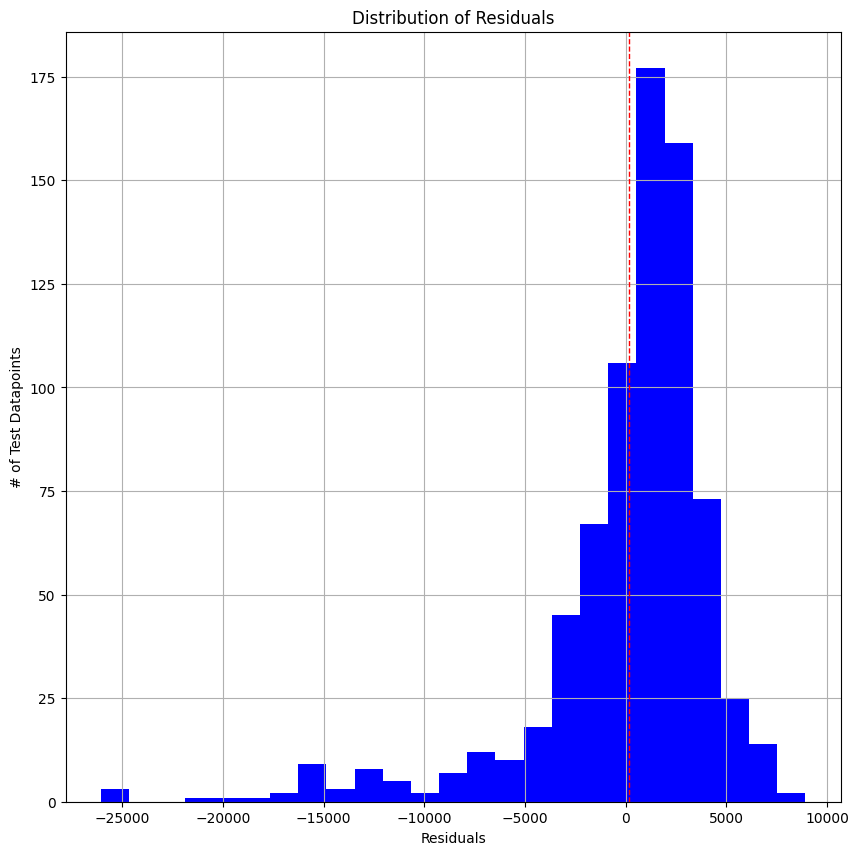

In [290]:
# Visualizing the distribution of Residuals
all_residuals = test_y - test_y_pred

pd.DataFrame({'Residuals': all_residuals}).hist(bins=25, figsize=(10,10), color = 'blue')

plt.xlabel('Residuals')
plt.ylabel('# of Test Datapoints')
plt.title('Distribution of Residuals')
plt.axvline(all_residuals.mean(), color='red', linestyle='dashed', linewidth=1);

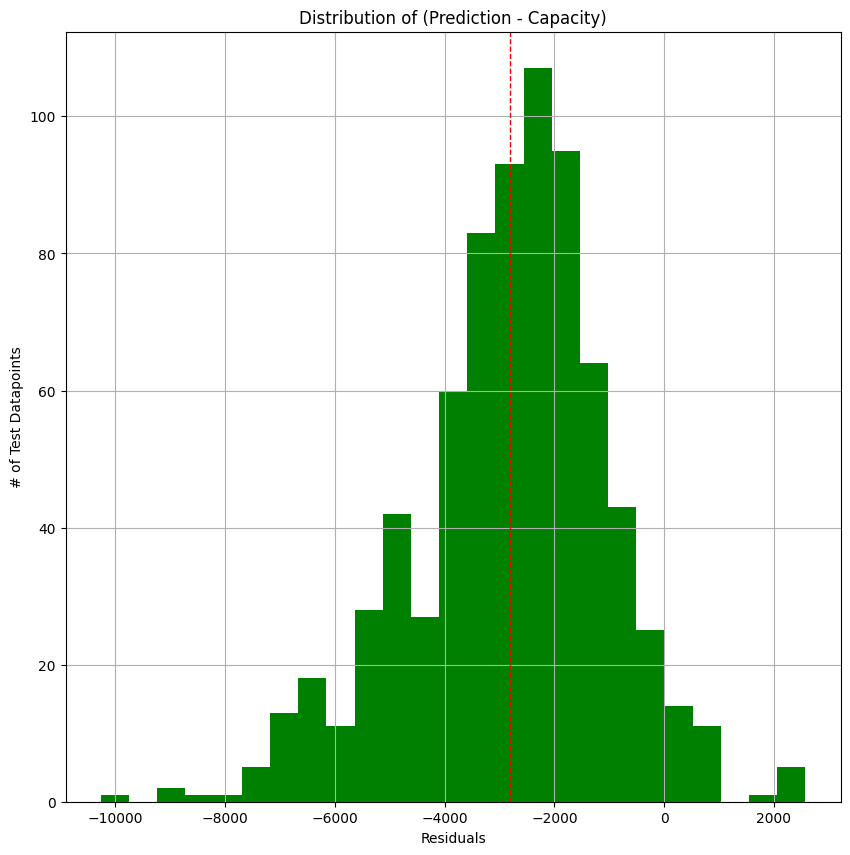

In [297]:
# Visualizing the distribution of difference between Capacity and Prediction.
difference = test_y_pred - test_x["Capacity"]

pd.DataFrame({'Difference': difference}).hist(bins=25, figsize=(10,10), color = 'green')

plt.xlabel('Residuals')
plt.ylabel('# of Test Datapoints')
plt.title('Distribution of (Prediction - Capacity)')
plt.axvline(difference.mean(), color='red', linestyle='dashed', linewidth=1);

From this visual, it is clear that more predictions under-predict the Attendance.

In [298]:
# Test Performance Measures for Test Set
r2_test = sklearn.metrics.r2_score(test_y, adjusted_test_y_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, adjusted_test_y_pred)

print('R-squared on Train Set: %0.2f' %r2_test)
print('RMSE on Train Set: %0.2f' %RMSE_train)

R-squared on Train Set: 0.58
RMSE on Train Set: 4387.72


The large increase in R squared makes sense because all predictions greater than the maximum capacity were set to the maximum capacity.

## Decision Tree Model

In [333]:
tree = DecisionTreeRegressor(random_state = 99)

# Starting with an initial guess for parameters
hyper_params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [20, 40, 60],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [334]:
dec_tree_cv = GridSearchCV(estimator = tree,
                        param_grid = hyper_params,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

### Fitting the Model

In [335]:
# Fit the model
dec_tree_cv.fit(train_x, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [10, 20, 30, 40, 50],
                         'min_samples_split': [20, 40, 60]},
             scoring='r2', verbose=1)

In [336]:
print(f"Initial score: {round(dec_tree_cv.best_score_, 4)}")
print(f"Initial parameters:{dec_tree_cv.best_params_}")

Initial score: 0.7464
Initial parameters:{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 60}


### Hyperparameter Tuning

In [337]:
# Adapt grid based on result from initial grid search
hyper_params_new = {
    'max_depth': list(range(2, 14)),
    'min_samples_split': list(range(5, 12)),
    'min_samples_leaf': list(range(35, 45))
}

In [338]:
dec_tree_cv = GridSearchCV(estimator = tree,
                        param_grid = hyper_params_new,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

### Re-fitting the Model With Hyperparameter Adjustments

In [339]:
# Re-fit the model
dec_tree_cv.fit(train_x, train_y)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


C:\Users\petew\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'min_samples_leaf': [35, 36, 37, 38, 39, 40, 41, 42,
                                              43, 44],
                         'min_samples_split': [5, 6, 7, 8, 9, 10, 11]},
             scoring='r2', verbose=1)

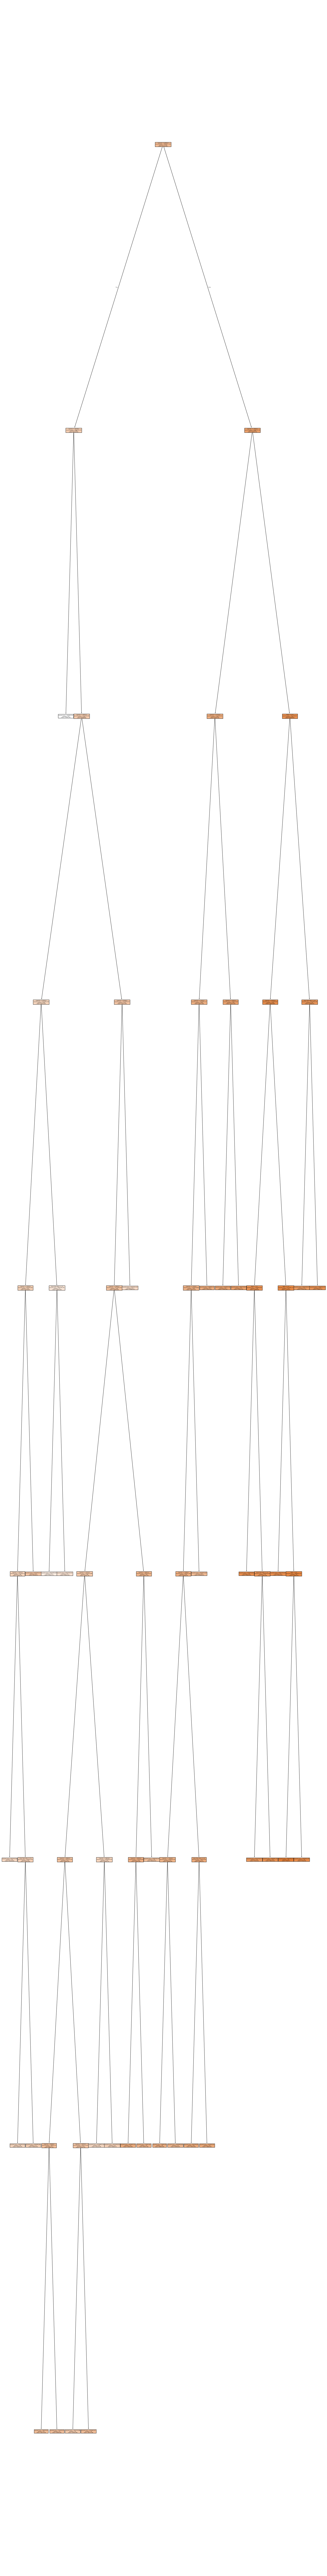

In [344]:
# Storing best model
bestRegTree = dec_tree_cv.best_estimator_

# Visualizing Decision Tree
fig = plt.figure(figsize = (25, 200))
a = tree.plot_tree(decision_tree = bestRegTree,
                   feature_names = train_x.columns,
                   filled = True)
fig.savefig("decision_tree.png", dpi=300, bbox_inches='tight')

In [345]:
y_pred = dec_tree_cv.predict(test_x)
r2 = sklearn.metrics.r2_score(test_y, y_pred)
RMSE = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print(f"R Squared: {round(r2, 4)}")
print(f"Root Mean Squared Error: {round(RMSE, 4)}")

R Squared: 0.7352
Root Mean Squared Error: 3544.9275


In [346]:
# Storing importance values from the best fit model
dec_tree_importance = dec_tree_cv.best_estimator_.feature_importances_

In [347]:
# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, dec_tree_importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,Capacity,0.989551
1,Week,0.006766
2,Home Team Wins,0.002762
3,Away Team Wins,0.000921
4,International,0.000000
5,Time_1,0.000000
6,Time_2,0.000000
7,Time_3,0.000000
8,Time_4,0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

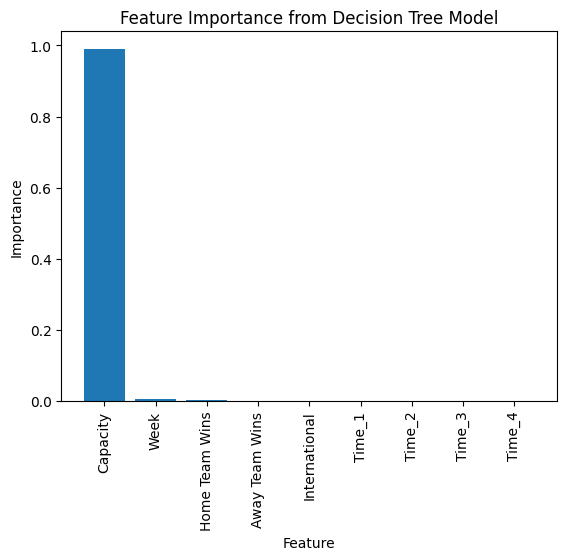

In [307]:
plt.bar(feature_imp["Feature"], feature_imp["Importance"])

plt.xticks(rotation = 90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance from Decision Tree Model")
plt.show

#### In the Decision Tree Model, Capacity accounted for nearly all of the feature importance in predicting fan attendance at NFL Games. Week of the game was the second most important variable in predicting attendance, followed by Number of Wins the Home Team had before the game.

## Random Forest Model

In [308]:
forest = RandomForestRegressor(random_state = 42)

# Start with an initial guess for parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 10, 20]}


In [309]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = RandomizedSearchCV(estimator = forest,
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'r2',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1)

### Fitting the Model

In [310]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training time: 272.01867866516113s


In [311]:
print(f"Initial score: {round(model_cv.best_score_, 4)}")
print(f"Initial parameters:{model_cv.best_params_}")

Initial score: 0.7752
Initial parameters:{'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}


### Hyperparameter Tuning

In [312]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [3, 5, 7],
    'min_samples_split': [7, 8, 9, 10, 11, 12],
    'n_estimators': [325, 350, 375]
}

print(param_grid)

{'max_depth': [20, 25, 30], 'min_samples_leaf': [3, 5, 7], 'min_samples_split': [7, 8, 9, 10, 11, 12], 'n_estimators': [325, 350, 375]}


### Re-fitting the Model

In [313]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = forest,
                        param_grid = param_grid,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [314]:
# Re-fit the model
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\petew\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training time: 663.2804765701294s


In [315]:
print(f"Improved score: {round(model_cv.best_score_, 4)}")
print(f"Improved parameters:{model_cv.best_params_}")

Improved score: 0.7752
Improved parameters:{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 325}


In [215]:
# Saving model to local drive
filename = 'RandomForest_model.sav'
pickle.dump(model_cv, open(filename, 'wb'))

### Feature Importance

In [320]:
# Storing importance values from the best fit model
importance = model_cv.best_estimator_.feature_importances_


In [321]:
# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, importance.round(4))),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,Capacity,0.8997
1,Week,0.0398
2,Home Team Wins,0.0310
3,Away Team Wins,0.0233
4,International,0.0061
5,Time_3,0.0001
6,Time_1,0.0000
7,Time_2,0.0000
8,Time_4,0.0000


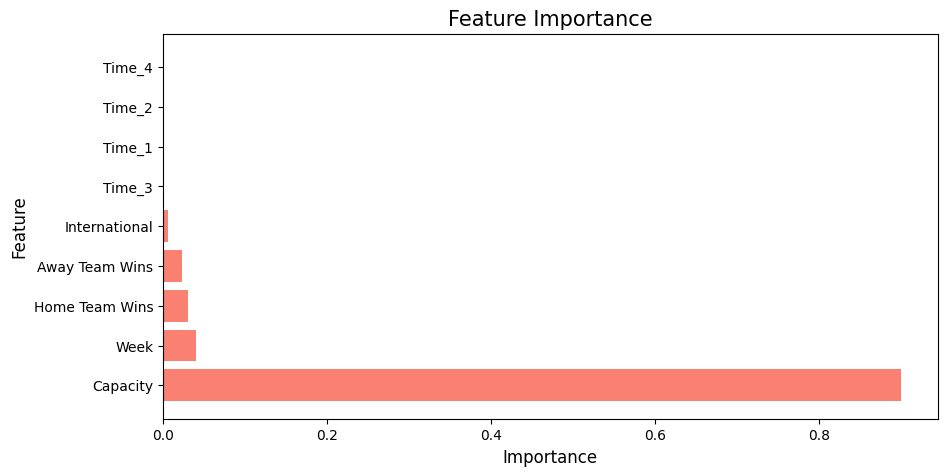

In [322]:
# Bar plot
plt.figure(figsize=(10, 5), dpi = 100)
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color ='salmon')

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)
plt.title("Feature Importance", fontsize = 15);

Similar to the Decision Tree Model, the Random Forest Model relies mainly on same 3 variables. However, the Random Forest Model made use of the Away Team Wins and International variable.

In [330]:
RF_y_pred = model_cv.predict(test_x)

r2_test = sklearn.metrics.r2_score(test_y, RF_y_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, RF_y_pred)

print('R-squared on Train Set: %0.2f' %r2_test)
print('RMSE on Train Set: %0.2f' %RMSE_train)

R-squared on Train Set: 0.78
RMSE on Train Set: 4387.72
